In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import datetime as dt


In [ ]:
df=pd.read_csv('/content/jena_climate_2009_2016.csv')

In [ ]:
df['Date Time']=pd.to_datetime(df['Date Time'], dayfirst=True)

In [ ]:
df.set_index('Date Time', inplace=True)

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


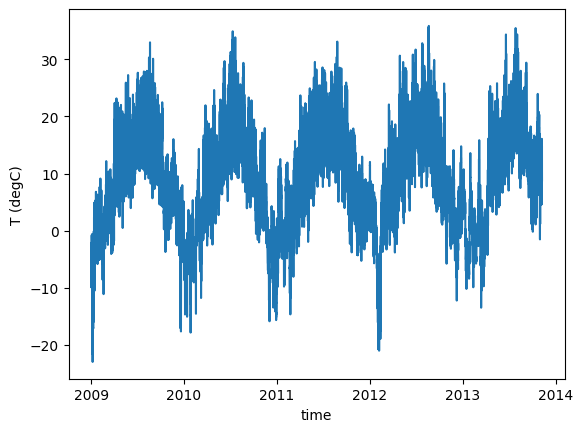

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("time")
plt.ylabel("T (degC)")
plt.plot(df['T (degC)'],)

In [ ]:
#Code référence de création de séquences
from sklearn.preprocessing import MinMaxScaler

# 1. Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

# 2. Création des séquences
def create_dataset(
    dataset,           #Remplacez par votre array NumPy (shape = (n_samples, n_features))
    time_step=1,       #Nombre de pas de temps à prendre en entrée
    input_cols=[0],    #Index(es) des colonne(s) d’entrée (ex. [0] pour univarié, [0,1,2] pour multivarié)
    target_col=0       #Index de la colonne à prédire (ex. 0 pour première colonne)
):
    dataX, dataY = [], []
    n_samples = len(dataset)
    for i in range(n_samples - time_step - 1):
        # 1) Fenêtre d'entrée (time_step, n_features_entrée)
        window = dataset[i : i + time_step, input_cols]

        dataX.append(window)
        # 2) Valeur cible
        target = dataset[i + time_step, target_col]

        dataY.append(target)
    return np.array(dataX), np.array(dataY)


In [ ]:
# Correlation matrix
correlation_matrix = df.corr()['T (degC)']
print(correlation_matrix)

p (mbar)          -0.021508
T (degC)           1.000000
Tpot (K)           0.997109
Tdew (degC)        0.904839
rh (%)            -0.557717
VPmax (mbar)       0.948853
VPact (mbar)       0.874629
VPdef (mbar)       0.754318
sh (g/kg)          0.873566
H2OC (mmol/mol)    0.874014
rho (g/m**3)      -0.965872
wv (m/s)           0.083343
max. wv (m/s)      0.119919
wd (deg)           0.068720
Name: T (degC), dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(df)

In [ ]:
train = int(len(data)*0.75)
test = len(data)-train
train_data,test_data=data[0:train,:],data[train:len(data),:]

In [ ]:
X_train, y_train = create_dataset(train_data, time_step=144,
    input_cols=[1,3,5,6,7,8,9,10],
    target_col=1)
X_test, ytest = create_dataset(test_data, time_step=144,
    input_cols=[1,3,5,6,7,8,9,10],
    target_col=1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64)

Epoch 1/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 0.0025 - val_loss: 7.2929e-05
Epoch 2/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 5.1855e-05 - val_loss: 4.0665e-05
Epoch 3/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 2.8332e-05 - val_loss: 3.2949e-05
Epoch 4/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step - loss: 2.0497e-05 - val_loss: 3.8675e-05
Epoch 5/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - loss: 1.7863e-05 - val_loss: 1.5878e-05
Epoch 6/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 1.6046e-05 - val_loss: 1.1723e-05
Epoch 7/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 1.5881e-05 - val_loss: 1.0256e-05
Epoch 8/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 1.5541e-05 - val_loss: 1.2599e-05
Epoch 9/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 1.4744e-05 - val_loss: 1.1653e-05
Epoch 10/10
2991/2991 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 1.4198e-05 - val_loss: 2.1494e-05


In [ ]:
y_pred=model.predict(X_test)

1991/1991 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step


In [ ]:
y_pred.shape

(63693, 1)

In [ ]:
ytest.shape

(63693,)

In [ ]:
dummy_full = np.zeros((len(y_pred), data.shape[1]))
dummy_full[:, 1] = y_pred[:, 0]
predicted_inverse = scaler.inverse_transform(dummy_full)[:, 1]

dummy_actual = np.zeros((len(ytest), data.shape[1]))
dummy_actual[:, 1] = ytest
actual_inverse = scaler.inverse_transform(dummy_actual)[:, 1]

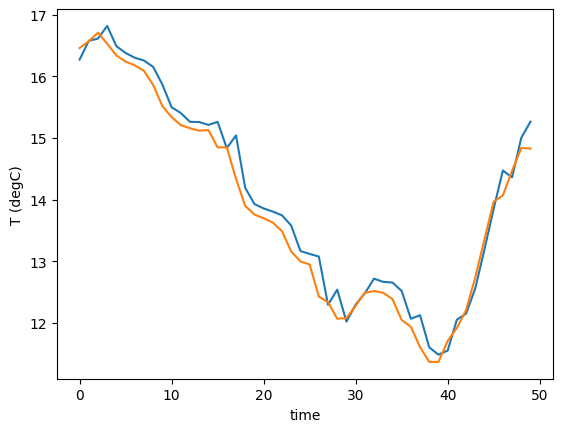

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("time")
plt.ylabel("T (degC)")
plt.plot(predicted_inverse[:50])
plt.plot(actual_inverse[:50])
